# Drug to Drug Interaction (DDI) - Exploratory Data Analysis (EDA)

In [2]:
# install packages for the project
# pip install pandas numpy py7zr rdkit-pypi
import pandas as pd
import numpy as np
import py7zr
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw, MolToSmiles, AllChem
from sklearn.ensemble import RandomForestClassifier

## Data Analysis

- Load the DrugBank data/pharma.7z
  - Extract the CSV file
  - Load the csv into a pandas dataframe
- Review the data   
  - Check the data types
  - Preview the data
    - Rename the columns to lowercase
- Identify the features
  - Rename the target feature
  - Identify the categorical and numeric features
  - Identify the target variables    
- Clean up the data
  - Remove null values
  - Remove duplicates  
- Identify Feature importance
  - Principal Component Analysis (PCA) features    
    - Correlation analysis    
  - Review Structural Similarity Profile (SSP) for drug pairs  
    - Get the SMILE code for all the drugs
      - Calculate the SSP 
    - Correlation analysis
- Load the drug information
  - Load drugbank look up information
  - Visualize the drug molecules
- Check the target values
  - Check the class balance in the data
  - Check the interaction types

In [ ]:
# read the data from ./data/pharma.7z file. unzip the file and read the csv file
with py7zr.SevenZipFile('./data/pharma.7z', mode='r') as z:
    # list the files in the archive
    print(z.getnames())    
    z.extract(path='./data/')    
    z.close()

In [3]:
# read the csv file into a pandas dataframe
df = pd.read_csv('./data/Neuron_input.csv')

# set all the column names to lowercase
df.columns = map(str.lower, df.columns)

# check the dataframe and get the info of their data types
print(df.info())

# display the columns and their data types
print(df.dtypes)

# preview the data
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191808 entries, 0 to 191807
Columns: 105 entries, drug1_id to pc_100
dtypes: float64(100), int64(1), object(4)
memory usage: 153.7+ MB
None
drug1_id     object
drug1        object
drug2_id     object
drug2        object
y             int64
             ...   
pc_96       float64
pc_97       float64
pc_98       float64
pc_99       float64
pc_100      float64
Length: 105, dtype: object


,drug1_id,drug1,drug2_id,drug2,y,pc_1,pc_2,pc_3,pc_4,pc_5,...,pc_91,pc_92,pc_93,pc_94,pc_95,pc_96,pc_97,pc_98,pc_99,pc_100
0,DB04571,CC1=CC2=CC3=C(OC(=O)C=C3C)C(C)=C2O1,DB00460,COC(=O)CCC1=C2NC(\C=C3/N=C(/C=C4\N\C(=C/C5=N/C...,1,-0.725865,-2.660013,0.615662,-0.113241,-0.314912,...,0.113968,0.071103,0.05747,0.015822,-0.003996,-0.054127,-0.035013,-0.065355,0.062818,-0.073674
1,DB00855,NCC(=O)CCC(O)=O,DB00460,COC(=O)CCC1=C2NC(\C=C3/N=C(/C=C4\N\C(=C/C5=N/C...,1,3.253956,-1.657897,3.332491,-2.052966,1.058092,...,0.113968,0.071103,0.05747,0.015822,-0.003996,-0.054127,-0.035013,-0.065355,0.062818,-0.073674
2,DB09536,O=[Ti]=O,DB00460,COC(=O)CCC1=C2NC(\C=C3/N=C(/C=C4\N\C(=C/C5=N/C...,1,14.490078,-0.097631,-0.825958,0.958193,-1.082541,...,0.113968,0.071103,0.05747,0.015822,-0.003996,-0.054127,-0.035013,-0.065355,0.062818,-0.073674
3,DB01600,CC(C(O)=O)C1=CC=C(S1)C(=O)C1=CC=CC=C1,DB00460,COC(=O)CCC1=C2NC(\C=C3/N=C(/C=C4\N\C(=C/C5=N/C...,1,-2.079264,-3.947373,0.046811,0.149965,0.972238,...,0.113968,0.071103,0.05747,0.015822,-0.003996,-0.054127,-0.035013,-0.065355,0.062818,-0.073674
4,DB09000,CC(CN(C)C)CN1C2=CC=CC=C2SC2=C1C=C(C=C2)C#N,DB00460,COC(=O)CCC1=C2NC(\C=C3/N=C(/C=C4\N\C(=C/C5=N/C...,1,-3.772882,-1.382200,0.473197,1.936360,-1.428736,...,0.113968,0.071103,0.05747,0.015822,-0.003996,-0.054127,-0.035013,-0.065355,0.062818,-0.073674


In [4]:
# identify important features

# rename the target feature from y to interaction_type
target_feature = 'interaction_type'

# rename the target feature from y to interaction_type if it is not already named
if df.columns[-1] != target_feature:
    df.rename(columns={'y':target_feature}, inplace=True)

# check the number of unique values in each column
print(df.nunique())

# identify categorical and numerical features
# get a list of numeric features
features_numeric = list(df.select_dtypes(include=[np.number]).columns)

# get a list of object features and exclude the target feature 'heartdisease'
features_category = list(df.select_dtypes(include=['object']).columns)

# remove the target feature from the list of categorical features
features_numeric.remove(target_feature)

print('Categorical features',features_category)
print('Numerical features',features_numeric)


drug1_id            1638
drug1               1638
drug2_id            1611
drug2               1611
interaction_type      86
                    ... 
pc_96               1581
pc_97               1581
pc_98               1581
pc_99               1581
pc_100              1581
Length: 105, dtype: int64
Categorical features ['drug1_id', 'drug1', 'drug2_id', 'drug2']
Numerical features ['pc_1', 'pc_2', 'pc_3', 'pc_4', 'pc_5', 'pc_6', 'pc_7', 'pc_8', 'pc_9', 'pc_10', 'pc_11', 'pc_12', 'pc_13', 'pc_14', 'pc_15', 'pc_16', 'pc_17', 'pc_18', 'pc_19', 'pc_20', 'pc_21', 'pc_22', 'pc_23', 'pc_24', 'pc_25', 'pc_26', 'pc_27', 'pc_28', 'pc_29', 'pc_30', 'pc_31', 'pc_32', 'pc_33', 'pc_34', 'pc_35', 'pc_36', 'pc_37', 'pc_38', 'pc_39', 'pc_40', 'pc_41', 'pc_42', 'pc_43', 'pc_44', 'pc_45', 'pc_46', 'pc_47', 'pc_48', 'pc_49', 'pc_50', 'pc_51', 'pc_52', 'pc_53', 'pc_54', 'pc_55', 'pc_56', 'pc_57', 'pc_58', 'pc_59', 'pc_60', 'pc_61', 'pc_62', 'pc_63', 'pc_64', 'pc_65', 'pc_66', 'pc_67', 'pc_68', 'pc_69', 'pc

In [5]:
# clean the data
# check for missing values
missing_values = df.isnull().sum()
print('Number of missing values per feature',missing_values)

if missing_values is not None:
    # fill the missing values with zero
    print('Filling missing values with zero')
    df.fillna(0, inplace=True)

# check for duplicate rows
duplicate_rows = df.duplicated().sum()
print('Number of duplicate rows', duplicate_rows)
    
# keep the first occurence of the duplicate row and remove the rest
if duplicate_rows > 0:
    print('Removing duplicate rows')
    df.drop_duplicates(keep='first', inplace=True)


Number of missing values per feature drug1_id            0
drug1               0
drug2_id            0
drug2               0
interaction_type    0
                   ..
pc_96               0
pc_97               0
pc_98               0
pc_99               0
pc_100              0
Length: 105, dtype: int64
Filling missing values with zero
Number of duplicate rows 0


In [45]:
# load the drugbank dataset for the drug names
df_drugbank = pd.read_csv('./data/drugbank_slim_df.csv')
print(df_drugbank.info())
print(df_drugbank.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11414 entries, 0 to 11413
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           11414 non-null  int64  
 1   drugbank_id  11414 non-null  object 
 2   name         11414 non-null  object 
 3   type         11414 non-null  object 
 4   groups       11414 non-null  object 
 5   categories   6685 non-null   object 
 6   SMILES       10763 non-null  object 
 7   PubChem_CID  8720 non-null   float64
dtypes: float64(1), int64(1), object(6)
memory usage: 713.5+ KB
None
   id drugbank_id          name            type                    groups  \
0   5     DB00006   Bivalirudin  small molecule  approved|investigational   
1   6     DB00007    Leuprolide  small molecule  approved|investigational   
2  13     DB00014     Goserelin  small molecule                  approved   
3  25     DB00027  Gramicidin D  small molecule                  approved   
4  33     DB00035 

['Trioxsalen', 'Verteporfin']


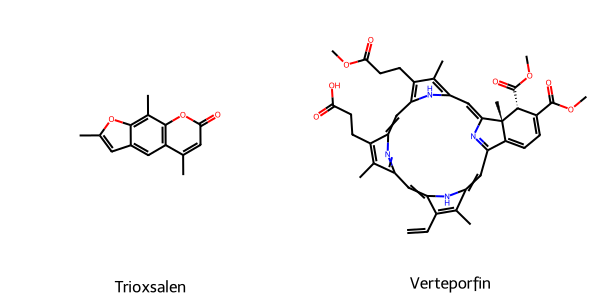

In [46]:
# SMILES (Simplified Molecular Input Line Entry System) is a specification in the form of a line notation for describing the structure of chemical species using short ASCII strings.
# get the first record and decode the smiles string from drug1 and drug2 columns
drug1 = df['drug1'][0]
drug2 = df['drug2'][0]

def smiles_to_name(smiles_code):
    mol = Chem.MolFromSmiles(smiles_code)
    name = df_drugbank.filter(['name'], axis=1).loc[df_drugbank['SMILES'] == smiles_code].values[0][0]
    return mol, name

mol1, name1 = smiles_to_name(drug1)
mol2, name2 = smiles_to_name(drug2)

legend  = [name1, name2]
print(legend)

# draw the molecules
Draw.MolsToGridImage([mol1, mol2], legends=legend, molsPerRow=2, subImgSize=(300, 300))


49    60751
47    34360
73    23779
75     9470
60     8397
      ...  
28       11
1        11
52       10
26        7
42        6
Name: interaction_type, Length: 86, dtype: int64


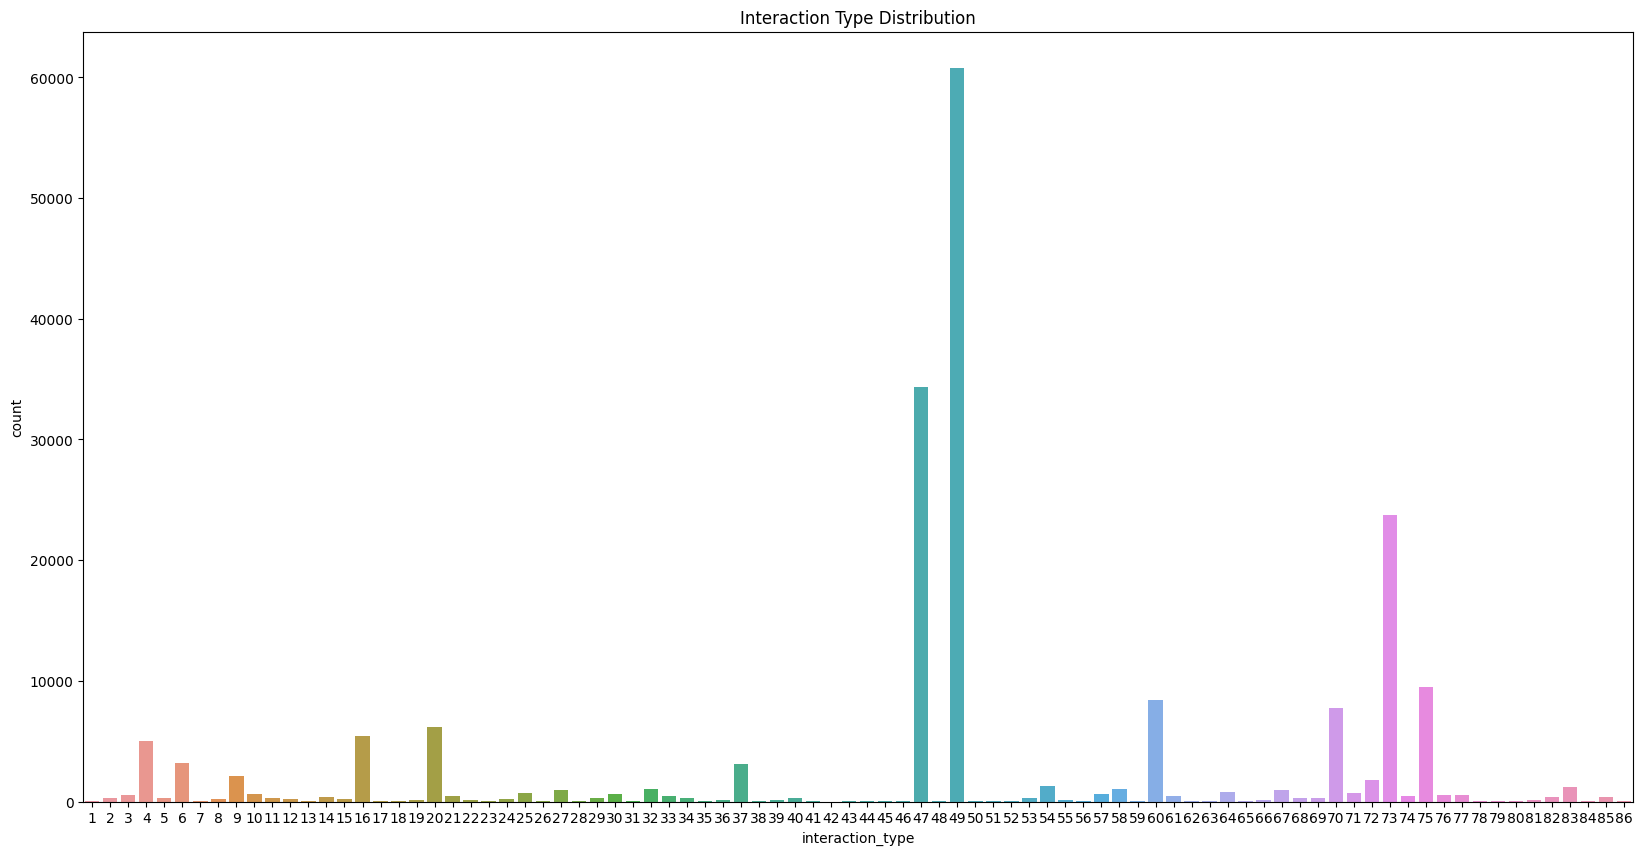

In [47]:
# get the distinct values for y and count the number of each value and sort and increasing order
target_counts = df[target_feature].value_counts()
print(target_counts)

# create a large figure to plot the distribution of the target variable
plt.figure(figsize=(20, 10))
sns.countplot(x=target_feature, data=df)

plt.title('Interaction Type Distribution')
# save the image to a file ./images
plt.savefig('./images/ozkary-interaction-type-distribution.png')

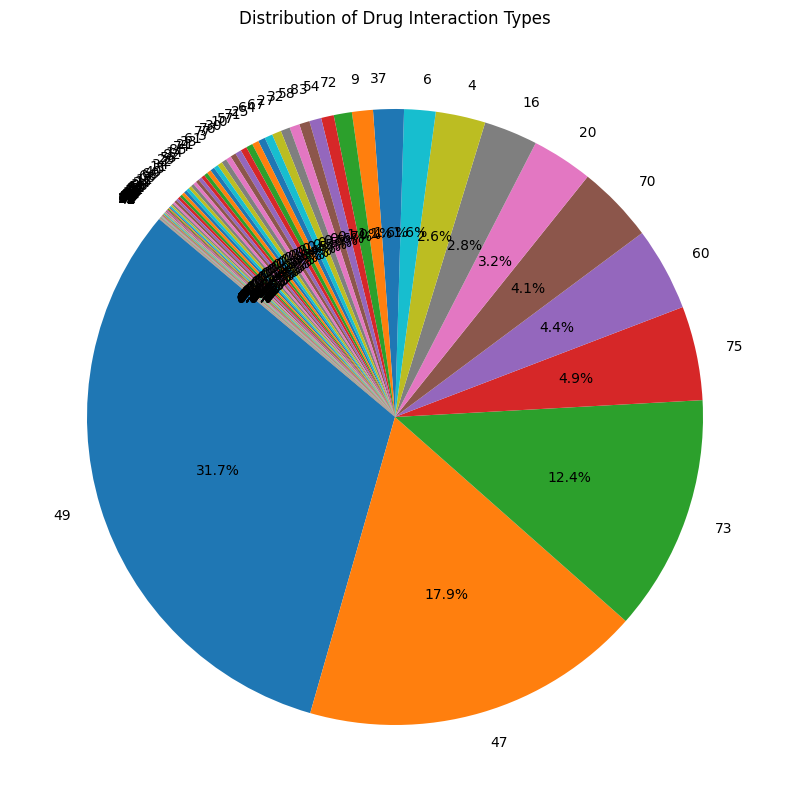

In [48]:
# check the class balance in the target variable
plt.figure(figsize=(10, 10))
plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Drug Interaction Types')
plt.savefig('./images/ozkary-interaction-type-class-balance.png')
# plt.show()

In [49]:
# load the interaction type dataset
df_interaction_type = pd.read_csv('./data/interaction_types.csv')

#rename the columns to lowercase and replace spaces with underscore
df_interaction_type.columns = map(str.lower, df_interaction_type.columns)
df_interaction_type.columns = df_interaction_type.columns.str.replace(' ', '_')

print(df_interaction_type.info())
print(df_interaction_type.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   interaction_type  86 non-null     int64 
 1   description       86 non-null     object
 2   subject           86 non-null     int64 
 3   ddi_type          86 non-null     object
dtypes: int64(2), object(2)
memory usage: 2.8+ KB
None
   interaction_type                                        description  \
0                67  #Drug1 can cause a decrease in the absorption ...   
1                18  #Drug1 can cause an increase in the absorption...   
2                13  The absorption of #Drug2 can be decreased when...   
3                 3  The bioavailability of #Drug2 can be decreased...   
4                62  The bioavailability of #Drug2 can be increased...   

   subject    ddi_type  
0        2  DDI type 1  
1        1  DDI type 2  
2        1  DDI type 3  
3        1  DDI type 4

: 

In [ ]:
# get the first DDI record and show what it means
ddi = df['interaction_type'][0]

# get the description of the DDI
description = df_interaction_type.filter(['description'], axis=1).loc[df_interaction_type['interaction_type'] == ddi].values[0][0]

# load the drug names previously stored in the legend variable
drug1 = legend[0]
drug2 = legend[1]

# show the interaction type and its description
description = description.replace('#Drug1', drug1).replace('#Drug2', drug2)

print(description)

   Feature  Importance
1     pc_2    0.017272
10   pc_11    0.015147
62   pc_63    0.014482
9    pc_10    0.014219
0     pc_1    0.013709
53   pc_54    0.013709
4     pc_5    0.013578
8     pc_9    0.013276
5     pc_6    0.013097
12   pc_13    0.012892


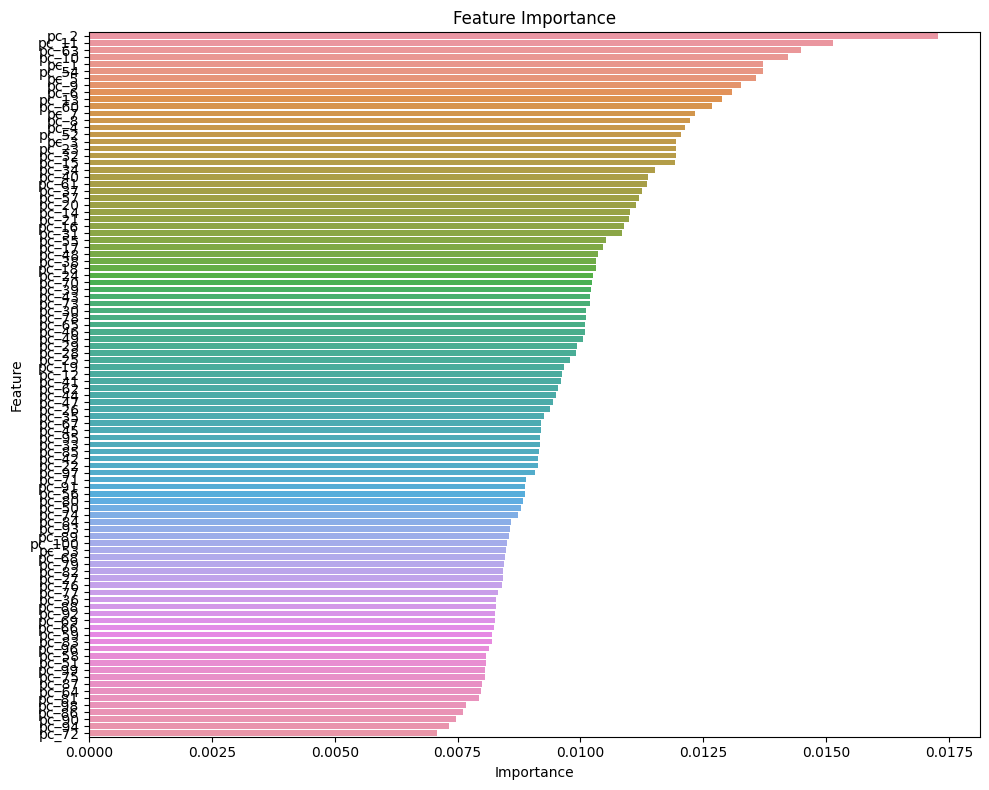

In [44]:
# Feature importance - Principal Component Analysis (PCA)

# the target variable has categorical values already converted to digits. 
# use a classifier to identify the important features instead of correlation matrix (binary target variable)

# use the pca numeric features as the input features
X = df[features_numeric]  
y = df[target_feature]

model = RandomForestClassifier()  # Use an appropriate model
model.fit(X, y)

# Create a DataFrame with feature names and their importance scores
feature_importance_df = pd.DataFrame({
    'Feature': features_numeric,
    'Importance': model.feature_importances_
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the first 10 most important features
print(feature_importance_df.head(10))

# plot the feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.tight_layout()
plt.savefig('./images/ozkary-pca-feature-importance.png')



In [8]:
# Feature importance - Structural Similarity Profile (SSP) for drug pairs  
def calculate_ssp(smiles_drug1, smiles_drug2):

    # check if the SMILE code is valid
    if smiles_drug1 is None or smiles_drug2 is None:
        return 0
    
    try:
        mol_drug1 = Chem.MolFromSmiles(smiles_drug1)
        mol_drug2 = Chem.MolFromSmiles(smiles_drug2)

        fp_drug1 = AllChem.GetMorganFingerprintAsBitVect(mol_drug1, 2, nBits=1024)
        fp_drug2 = AllChem.GetMorganFingerprintAsBitVect(mol_drug2, 2, nBits=1024)

        array_fp_drug1 = np.array(list(fp_drug1.ToBitString())).astype(int)
        array_fp_drug2 = np.array(list(fp_drug2.ToBitString())).astype(int)

        tanimoto_similarity = np.sum(np.logical_and(array_fp_drug1, array_fp_drug2)) / np.sum(np.logical_or(array_fp_drug1, array_fp_drug2))

        return tanimoto_similarity
    except:
        return 0
        


In [9]:
# for each drug pair, calculate the SSP and store the result in a new column
df['ssp'] = df.apply(lambda x: calculate_ssp(x['drug1'], x['drug2']), axis=1)


[13:49:14] SMILES Parse Error: syntax error while parsing: OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1
[13:49:14] SMILES Parse Error: Failed parsing SMILES 'OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1' for input: 'OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1'
[13:49:26] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:49:26] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:49:26] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:49:26] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:49:26] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:49:26] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:49:26] Explicit valence for atom # 0 N, 4, is greater

In [11]:
# use the ssp features as the input features
X = df[['ssp']]  
y = df[target_feature]

model = RandomForestClassifier()  # Use an appropriate model
model.fit(X, y)

feature_importance = model.feature_importances_
print("Feature Importance for SSP:", feature_importance)


Feature Importance for SSP: [1.]


In [17]:
# our analysis concludes that the SSP has a strong importance on the result
# we are using that information to build our our models.  
# save the SSP and interaction_type columns to a new dataframe
df_cleaned = df[['ssp', 'interaction_type']]
print(df_cleaned.info())

# save the information to a compressed csv file
df_cleaned.to_csv('./data/ssp_interaction_type.csv.gz', compression='gzip', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191808 entries, 0 to 191807
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ssp               191808 non-null  float64
 1   interaction_type  191808 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 2.9 MB
None
